In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Test_one/mnist_cnn_practice'

/content/drive/MyDrive/Test_one/mnist_cnn_practice


In [25]:
import numpy                    as np
import pandas                   as pd
import matplotlib.pyplot        as plt
import seaborn                  as sns
import tensorflow               as tf
import tensorflow.keras.backend as K
from tensorflow                 import keras
from tqdm import tqdm
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os

## 데이터세트 불러오기

In [4]:
# Download the mnist dataset using keras
data_train, data_test = tf.keras.datasets.mnist.load_data()

# Parse images and labels
(images_train, labels_train) = data_train
(images_test, labels_test) = data_test

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
images_train.shape

(60000, 28, 28)

In [6]:
images_train = images_train.reshape(images_train.shape[0],images_train.shape[1],images_train.shape[2],1)
images_test = images_test.reshape(images_test.shape[0],images_test.shape[1],images_test.shape[2],1)

In [7]:
labels_train_onehot = np.zeros((labels_train.shape[0],len(np.unique(labels_train))))

for i in range (labels_train.shape[0]):
    labels_train_onehot[i,labels_train[i]] = 1

In [8]:
labels_test_onehot  = np.zeros((labels_test.shape[0],len(np.unique(labels_test))))

for i in range (labels_test.shape[0]):
    labels_test_onehot[i,labels_test[i]] = 1

In [9]:
images_train.shape, labels_train_onehot.shape, images_test.shape, labels_test_onehot.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

.

.

.

.

.

## 모델 및 마지막 컨볼루션 레이어정보 불러오기

In [10]:
training_ = pd.read_csv('./[CNN_models]/Training_result.csv')
training_result = training_.sort_values('Accuracy',ascending = False)

In [11]:
N = len(training_result)
training_result # Case는 0부터 시작 CNN_case는 1부터 시작

,Case,Kernel_S,Dense_N,Learn_R,Accuracy
9,9.0,5.0,18.0,0.001,0.9853
11,11.0,5.0,24.0,0.001,0.9852
5,5.0,4.0,18.0,0.001,0.9838
6,6.0,4.0,21.0,0.001,0.9837
8,8.0,5.0,12.0,0.001,0.9832
10,10.0,5.0,21.0,0.001,0.9830
3,3.0,3.0,24.0,0.001,0.9825
7,7.0,4.0,24.0,0.001,0.9825
1,1.0,3.0,18.0,0.001,0.9822
4,4.0,4.0,12.0,0.001,0.9794


In [12]:
# model_case1 형식 (case별로 불러오기)
cases = range(1,N+1,1) 
for case in cases:
    temp_model = keras.models.load_model("[CNN_models]/CNN_case{}.h5".format(case))
    temp_last_conv_layer = [layer.name for layer in temp_model.layers][-5]
    exec('model_case{} = temp_model'.format(case))
    exec('last_conv_layer_case{} = temp_last_conv_layer'.format(case))

In [13]:
# model_rank1 형식 (rank별로 불러오기)
for rank in range(N): # CNN_case.h5는 1부터 시작, rank는 0부터 시작
    case_index = int(training_result.iloc[rank,0])+1 
    # print(rank+1, case_index)
    exec('model_rank{} = model_case{}'.format(rank+1,case_index))
    exec('last_conv_layer_rank{} = last_conv_layer_case{}'.format(case_index+1,case_index))

## Grad CAM 추출 및 시각화

#### Grad CAM 함수 정의

In [14]:
def get_img_array(img, size):
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    # array = np.expand_dims(array, axis=0)
    return array


In [15]:
def make_gradcam_heatmap(data_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel  = preds[:, pred_index]

    grads        = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

#### Grad CAM 추출(전체 테스트 데이터중 1000장 우선 추출)

In [16]:
numberOfdata = 1000
temp_data = images_test[:numberOfdata] # Grad CAM 추출하는데 너무 오래걸리면 1000장보다 줄이셔도 됩니다

In [17]:
if not os.path.isdir('[Grad_CAM]'):
    os.mkdir('./[Grad_CAM]')
    
cases = range(1,N+1,1)
for case in cases: # 각 모델별 추출
    print('case {}'.format(case))
    exec("temp_model           = model_case%d"%(case))
    exec("temp_last_conv_layer = last_conv_layer_case%d"%(case))
    last_conv_layer_outshape = [layer.output.shape[1] for layer in temp_model.layers][-5]
    
    temp_grad_CAMs = np.zeros((temp_data.shape[0] , last_conv_layer_outshape,last_conv_layer_outshape))
    
    for j in tqdm(range(temp_data.shape[0])): # 각 사진별로 그래드캠 추출

        temp_dataSample = temp_data[j]
        temp_dataSample = temp_dataSample.reshape(1, temp_dataSample.shape[0], temp_dataSample.shape[1],temp_dataSample.shape[2])

        temp_grad_cam   = make_gradcam_heatmap(temp_dataSample, temp_model, temp_last_conv_layer)

        temp_grad_CAMs[j] = temp_grad_cam
    
    exec("grad_CAMs_case%d = temp_grad_CAMs"%(case))
    exec("np.save('./[Grad_CAM]/grad_CAMs_case%d',grad_CAMs_case%d)"%(case,case))

    
    temp_grad_CAMs_inv   = temp_grad_CAMs[:, ::-1]

    
    exec("grad_CAMs_case%d_inv   = temp_grad_CAMs_inv  "%(case))
    exec("np.save('./[Grad_CAM]/grad_CAMs_case%d_inv',grad_CAMs_case%d_inv)"%(case,case))  

case 1


100%|██████████| 1000/1000 [00:27<00:00, 36.90it/s]


case 2


100%|██████████| 1000/1000 [00:11<00:00, 84.71it/s]


case 3


100%|██████████| 1000/1000 [00:11<00:00, 85.46it/s]


case 4


100%|██████████| 1000/1000 [00:11<00:00, 85.41it/s]


case 5


100%|██████████| 1000/1000 [00:11<00:00, 86.90it/s]


case 6


100%|██████████| 1000/1000 [00:11<00:00, 86.27it/s]


case 7


100%|██████████| 1000/1000 [00:11<00:00, 86.91it/s]


case 8


100%|██████████| 1000/1000 [00:11<00:00, 88.16it/s]


case 9


100%|██████████| 1000/1000 [00:11<00:00, 84.95it/s]


case 10


100%|██████████| 1000/1000 [00:11<00:00, 85.25it/s]


case 11


100%|██████████| 1000/1000 [00:11<00:00, 86.68it/s]


case 12


100%|██████████| 1000/1000 [00:11<00:00, 86.74it/s]


## 저장된 grad CAM 불러오는 코드

In [24]:
cases = range(1,N+1,1)
for case in cases:
    exec("grad_CAMs_case{} = np.load('./[Grad_CAM]/grad_CAMs_case{}.npy')".format(case,case))
    exec("grad_CAMs_case{}_inv = np.load('./[Grad_CAM]/grad_CAMs_case{}_inv.npy')".format(case,case))

### 확인용

In [ ]:
grad_CAMs_case1.shape

(10000, 7, 7)

In [ ]:
temp_grad_cam.shape

(7, 7)

In [ ]:
temp_dataSample.shape

(1, 28, 28, 1)

In [ ]:
temp_grad_CAMs.shape

(10000, 7, 7)

In [ ]:
temp_grad_CAMs_inv.shape

(10000, 7, 7)

In [ ]:
grad_CAMs_case1.shape

(1000, 7, 7)

.

.

.

.

.

### Grad CAM + 원본 이미지 시각화

In [26]:
model_builder = keras.applications.xception.Xception
img_size = (28, 28)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

In [27]:
# index_1: 실제 1 데이터 index 모음(test data 1000장 중)

for i in range(10):
    temp_index = list(np.where(labels_test_onehot[:numberOfdata,i] == 1))
    exec('index_{} = temp_index[0]'.format(i)) #nested array
len(index_0) # test data 1000장중 0인 사진이 85장

85

In [28]:
# 원본
def display_gradcam(img_data, heatmap, alpha=0.4):
    # Load the original image
    plt.figure(figsize = (6,6))

    img = keras.preprocessing.image.img_to_array(img_data)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet") # cmap 옵션 바꿔보기

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()



In [29]:
# ================수정필요===================== : 이미지가 한장씩밖에 표현 안되는데 이미지 여러장 넣어서 칼럼별로 볼 수 있도록 시각화 시켜보기
def display_gradcam(img_data, heatmap, alpha=0.4):
    n = len
    # Load the original image
    plt.figure(figsize = (6,6))

    img = keras.preprocessing.image.img_to_array(img_data)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("Blues")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


    # Display Grad CAM
    plt.imshow(superimposed_img)
    



In [30]:
# 확인용
heatmap_ = grad_CAMs_case1[index_1] # case1 model에서 1의 사진에 대한 grad CAM 적용 결과 heatmap
heatmap_.shape

(126, 7, 7)

total # of number  1 :  126


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


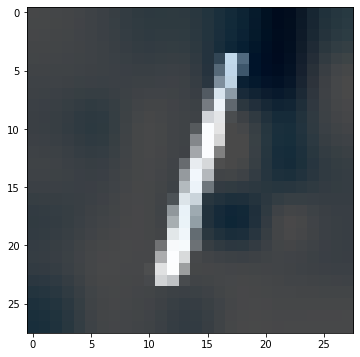

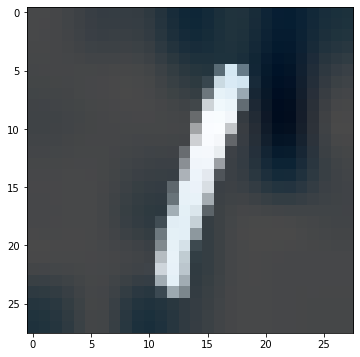

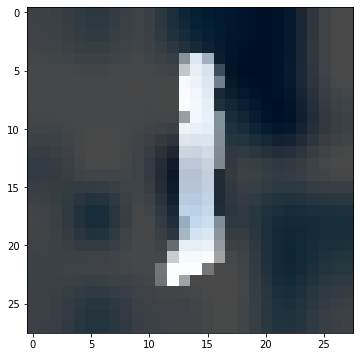

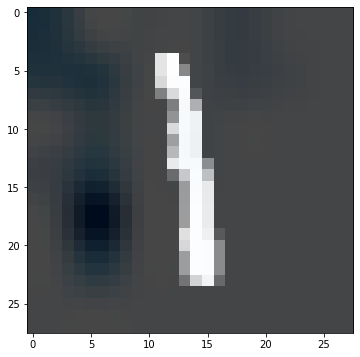

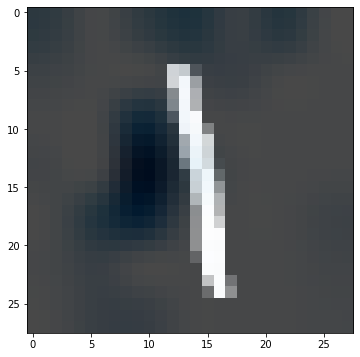

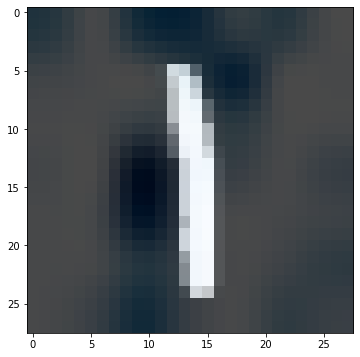

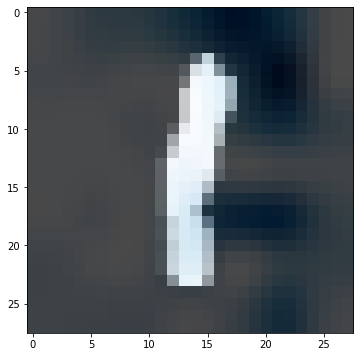

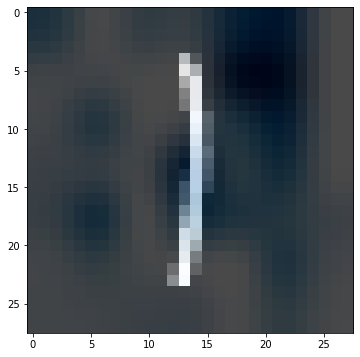

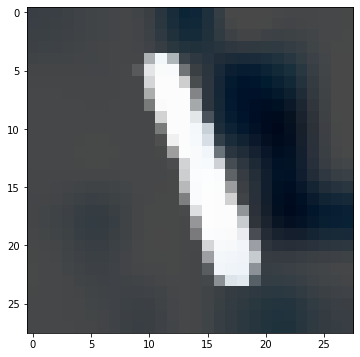

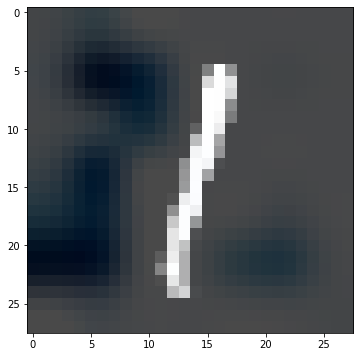

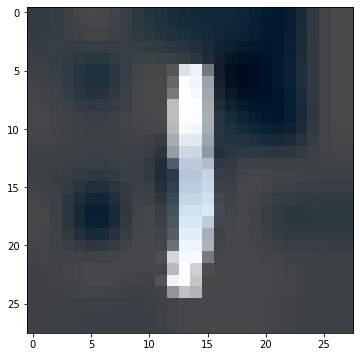

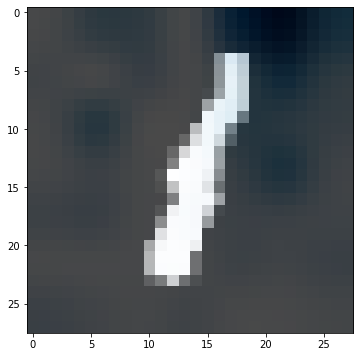

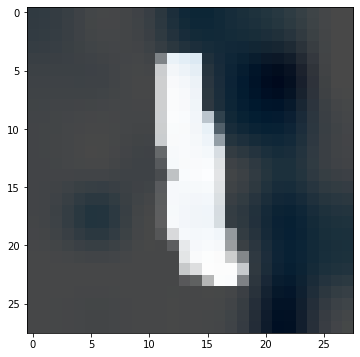

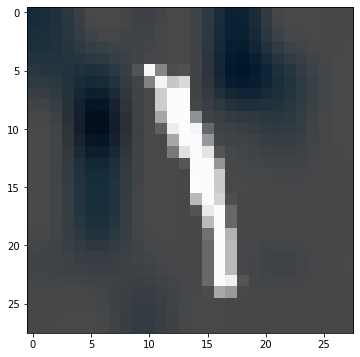

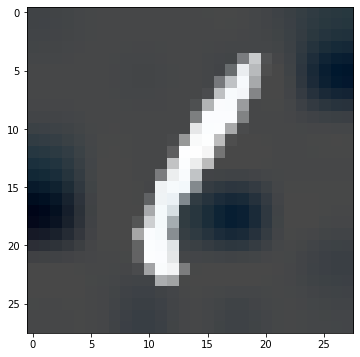

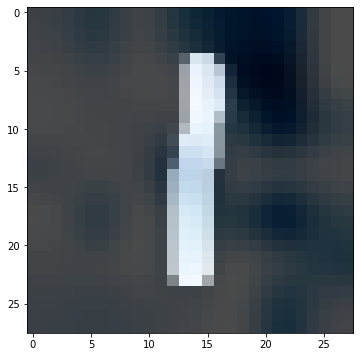

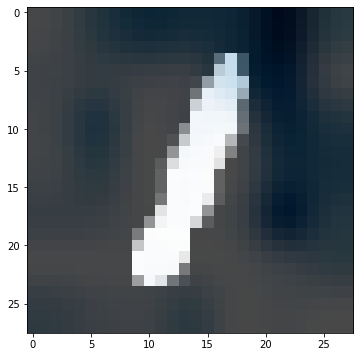

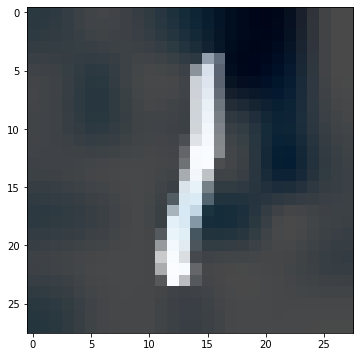

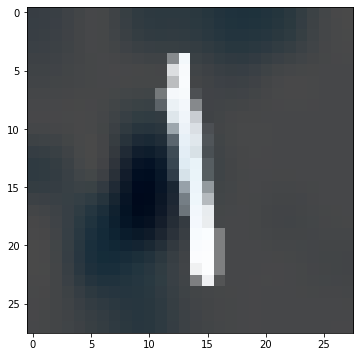

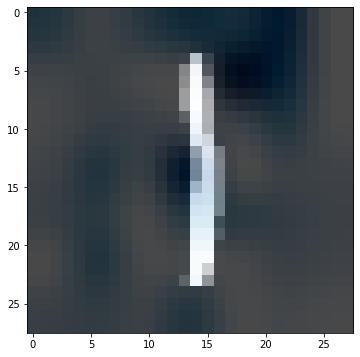

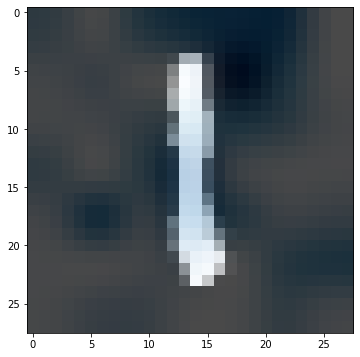

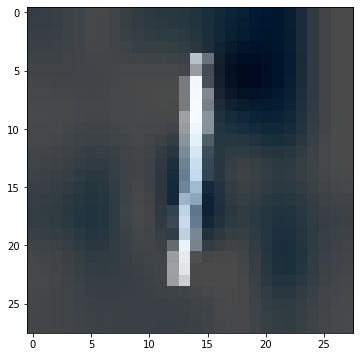

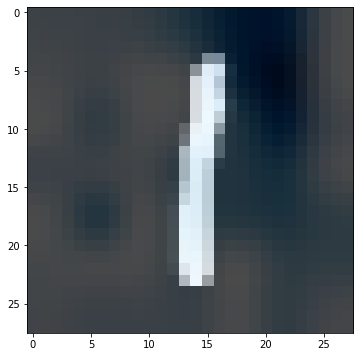

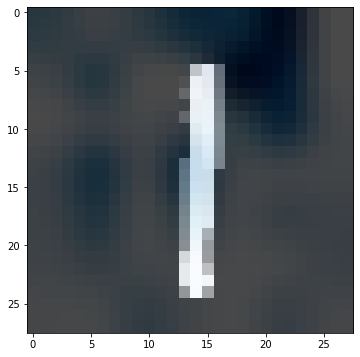

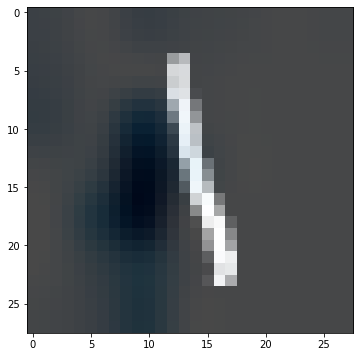

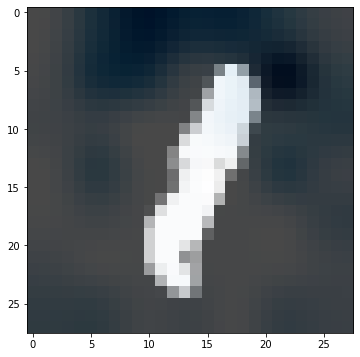

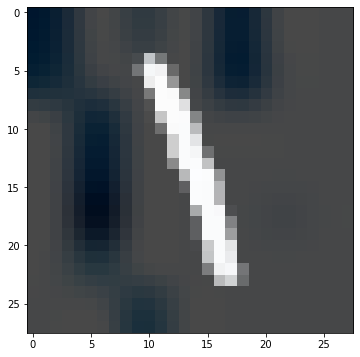

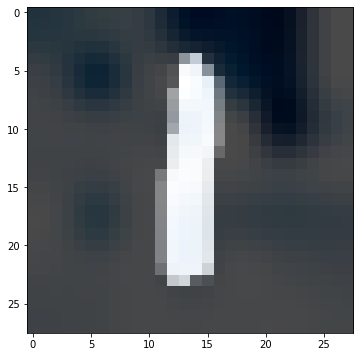

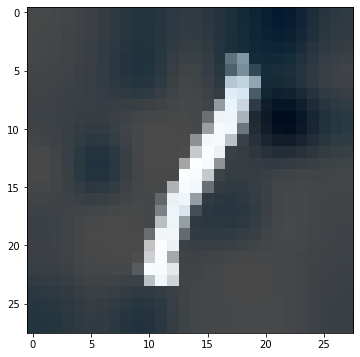

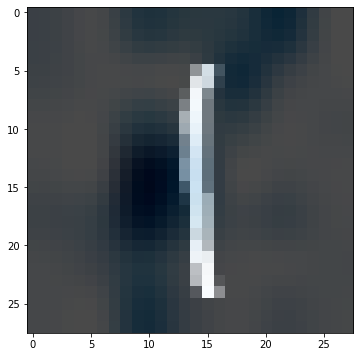

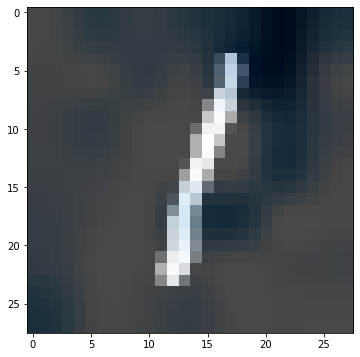

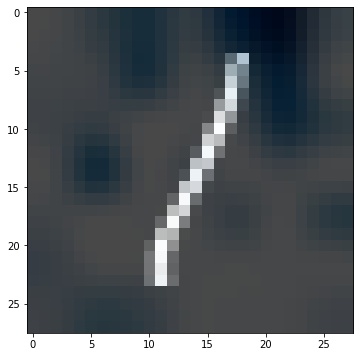

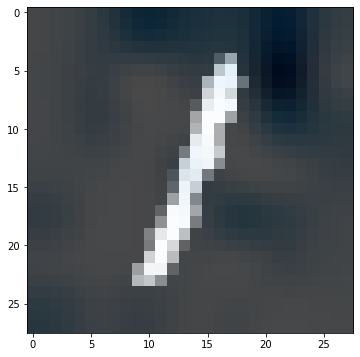

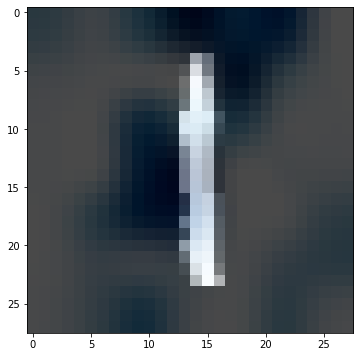

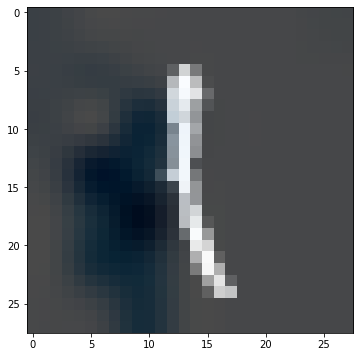

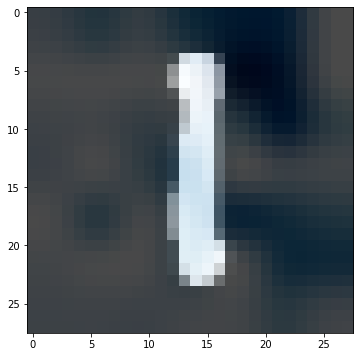

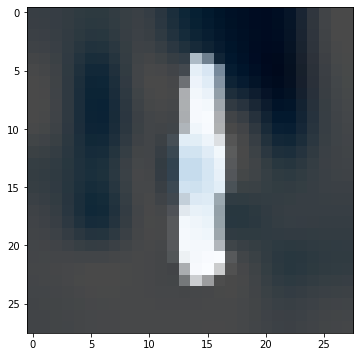

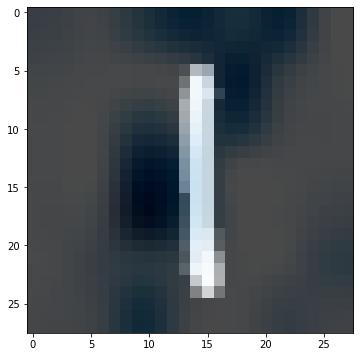

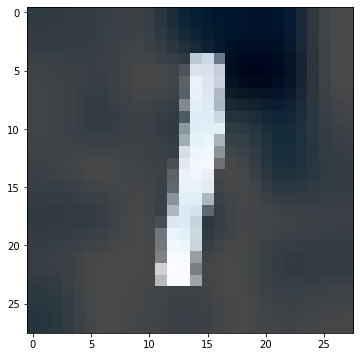

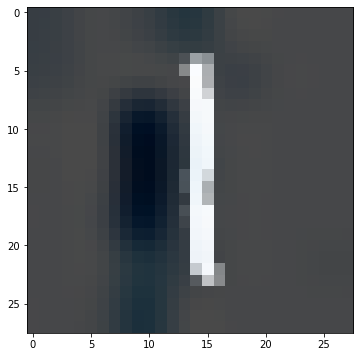

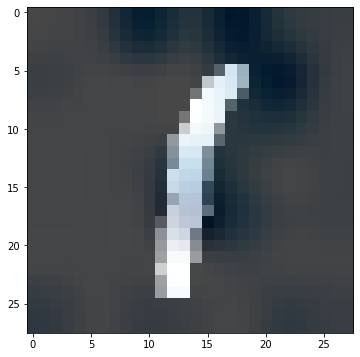

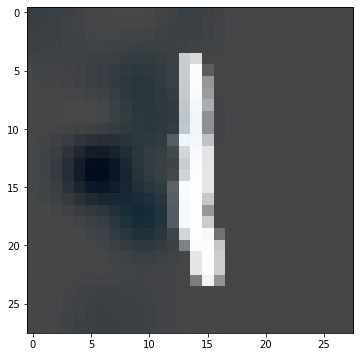

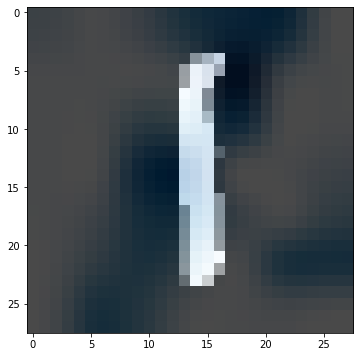

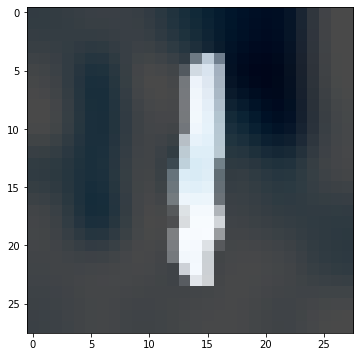

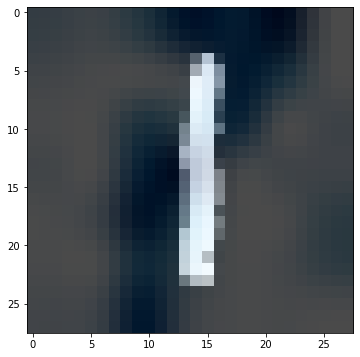

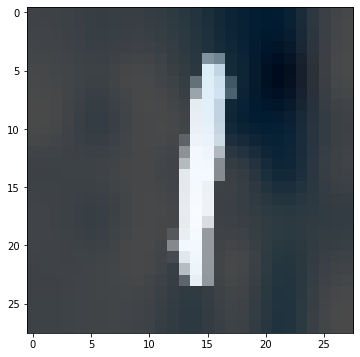

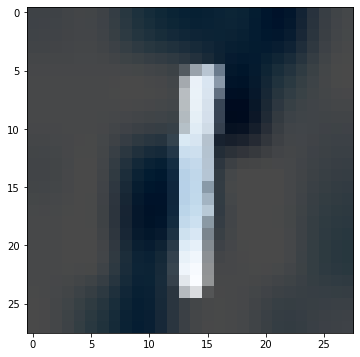

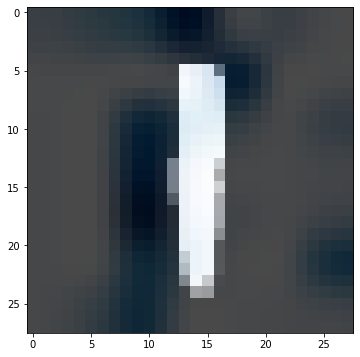

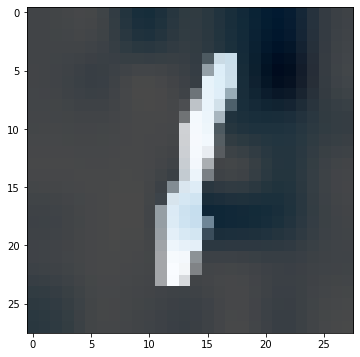

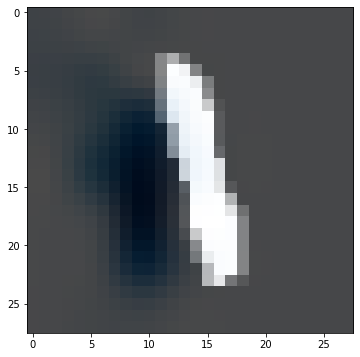

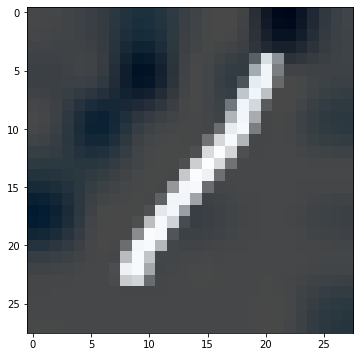

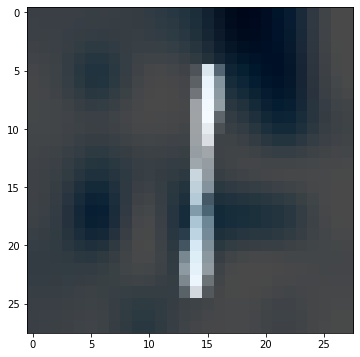

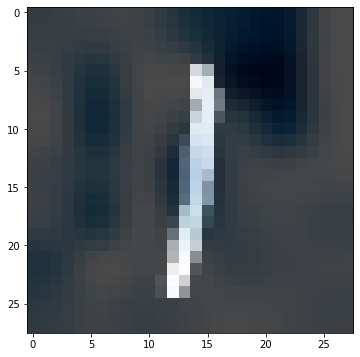

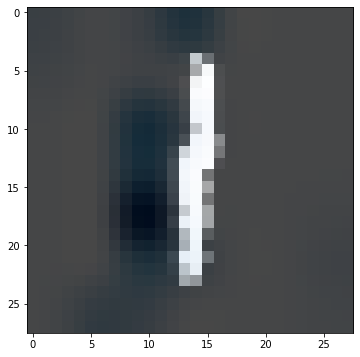

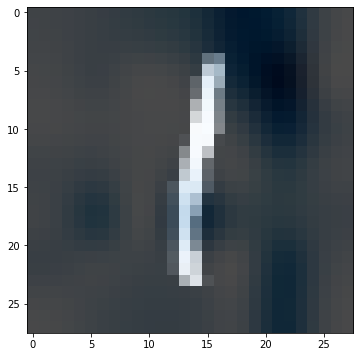

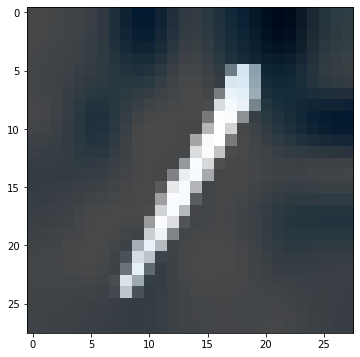

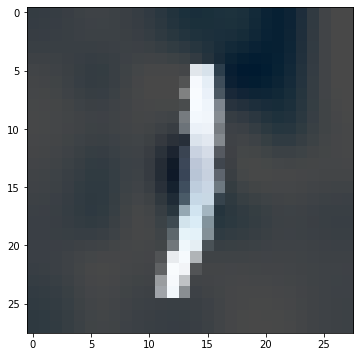

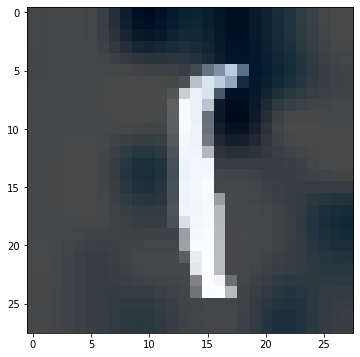

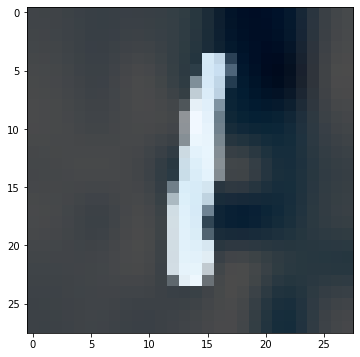

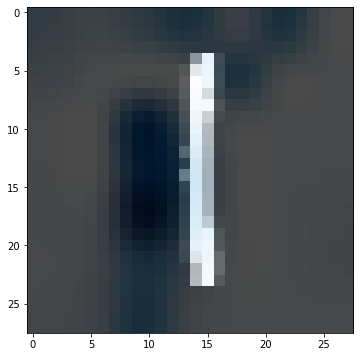

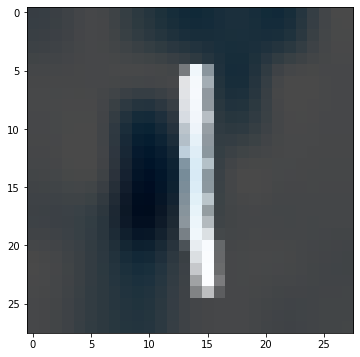

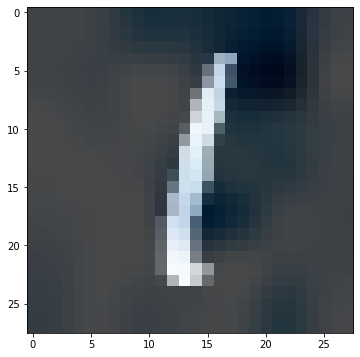

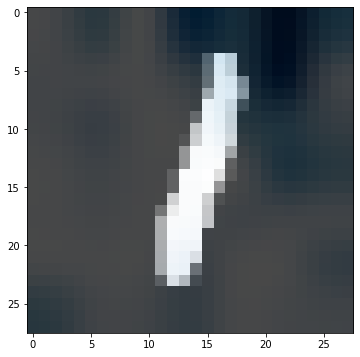

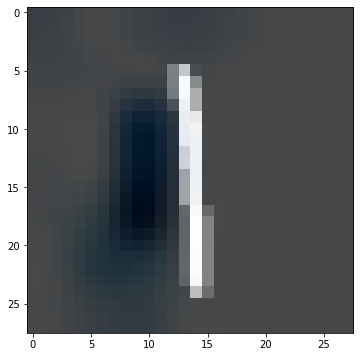

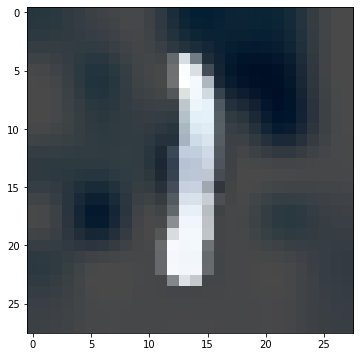

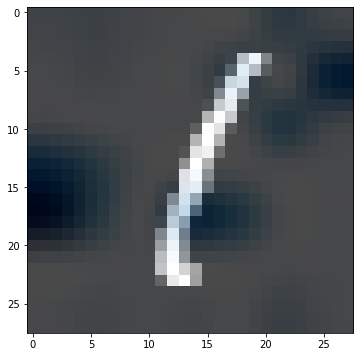

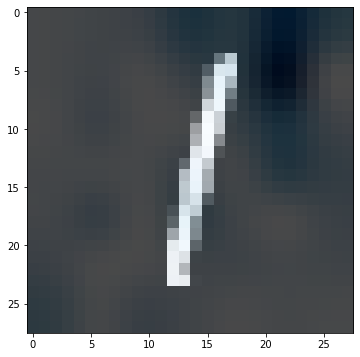

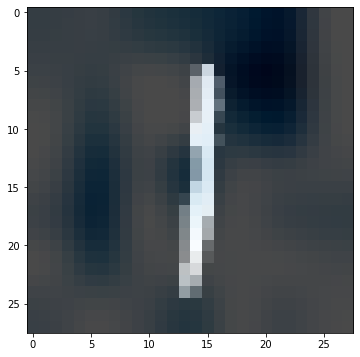

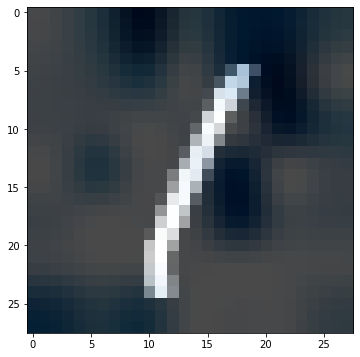

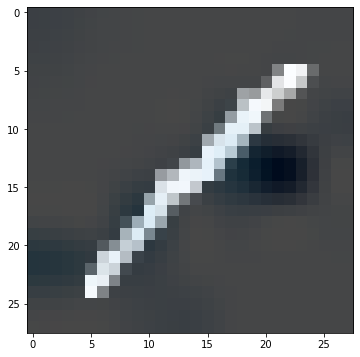

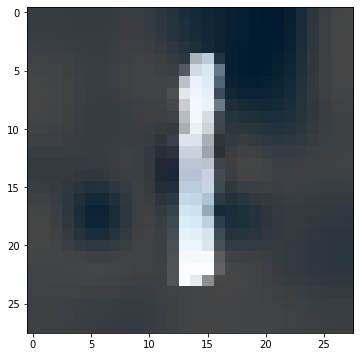

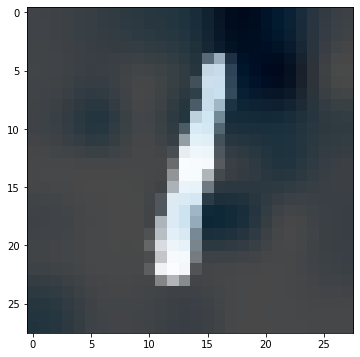

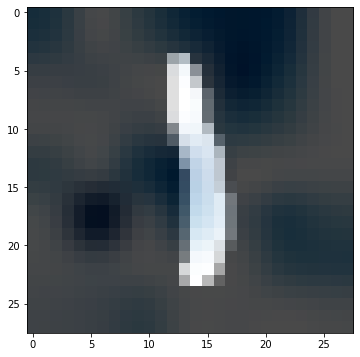

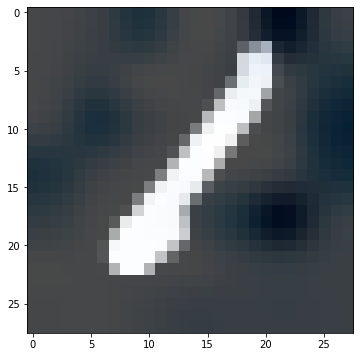

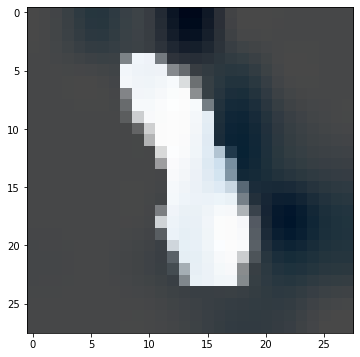

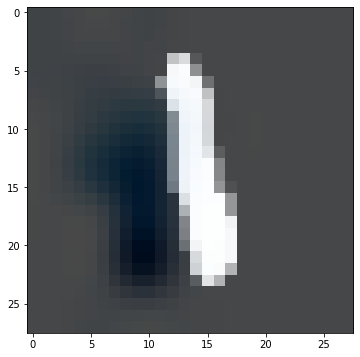

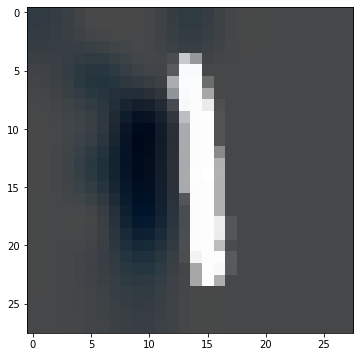

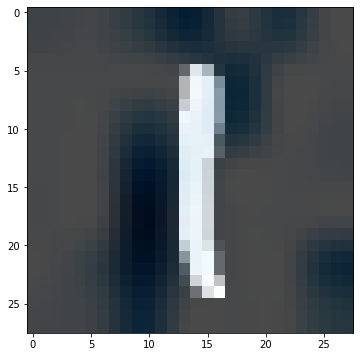

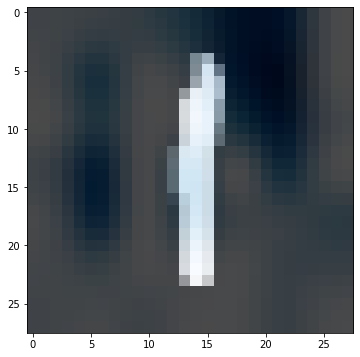

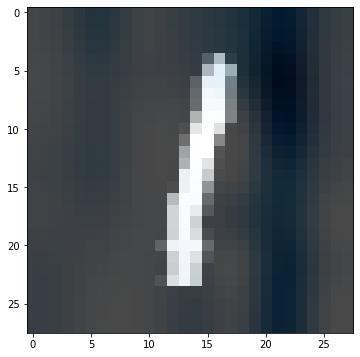

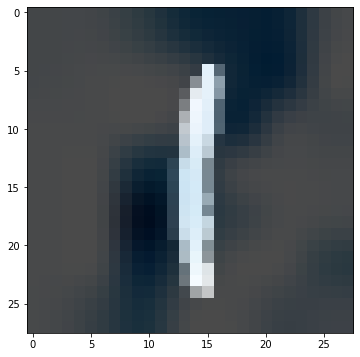

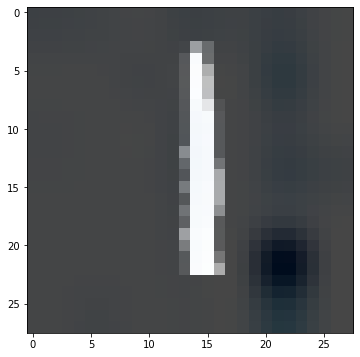

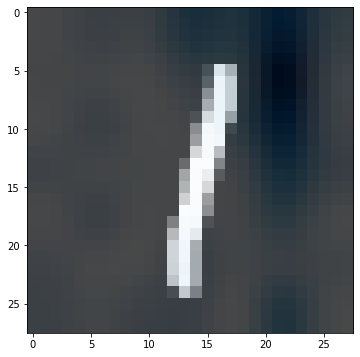

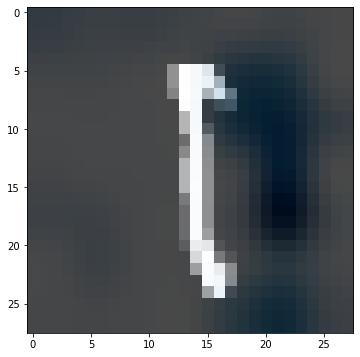

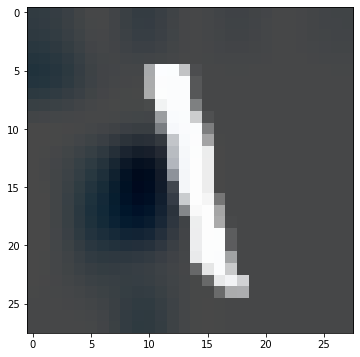

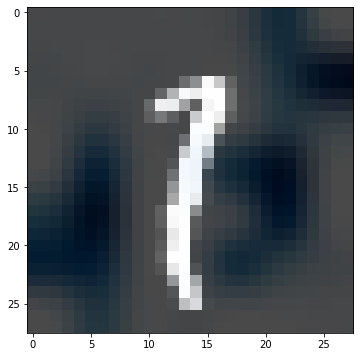

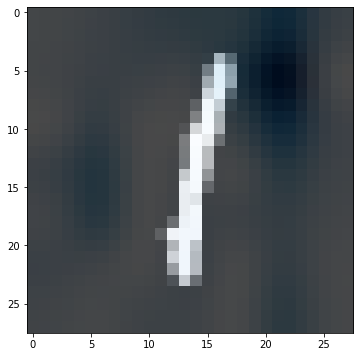

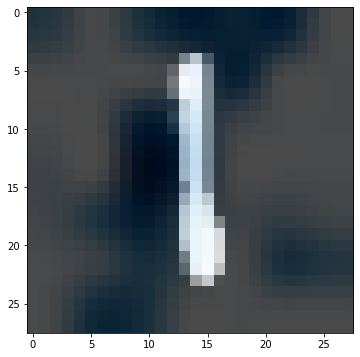

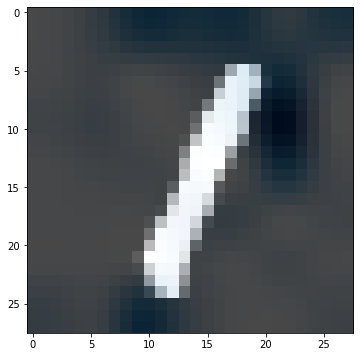

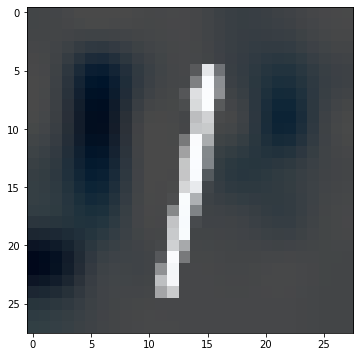

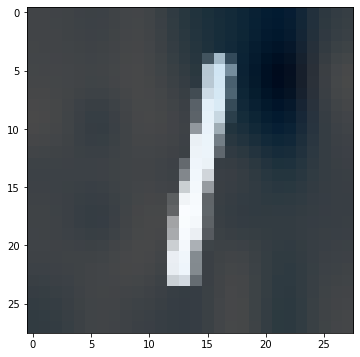

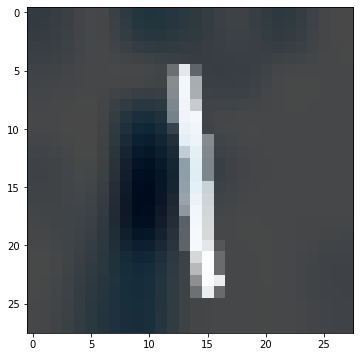

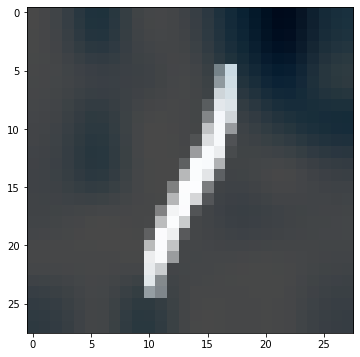

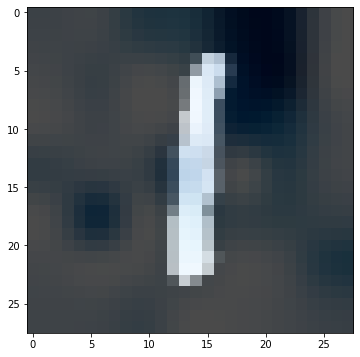

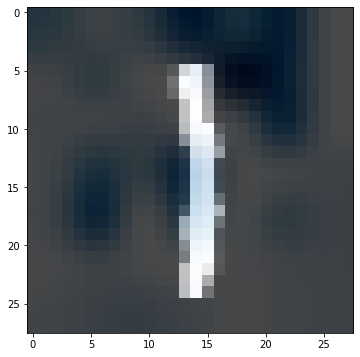

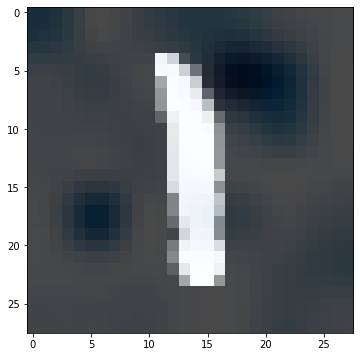

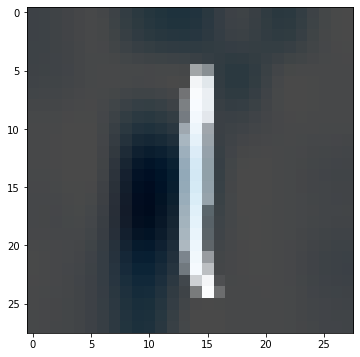

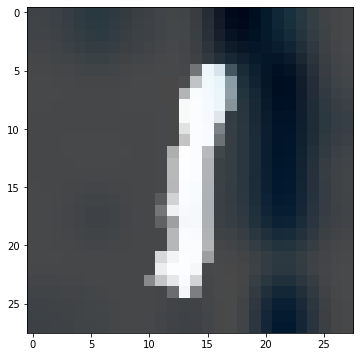

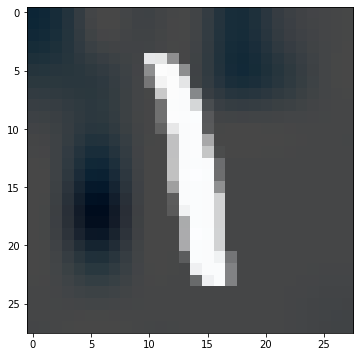

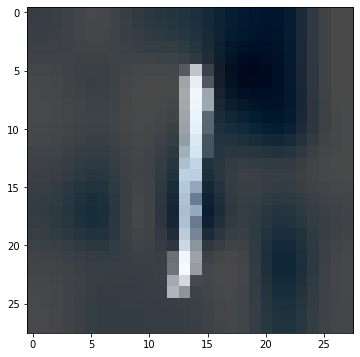

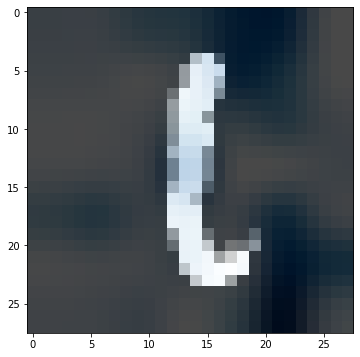

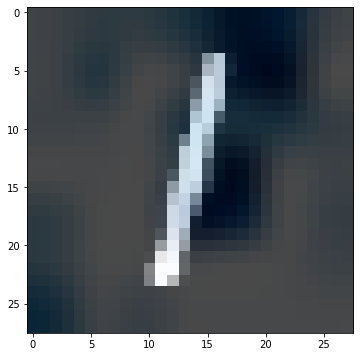

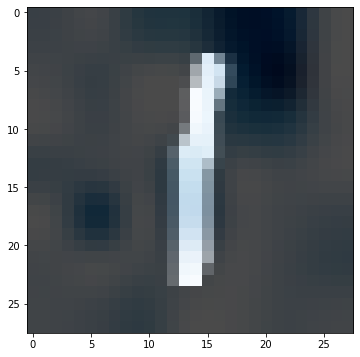

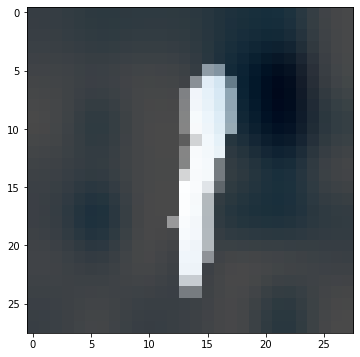

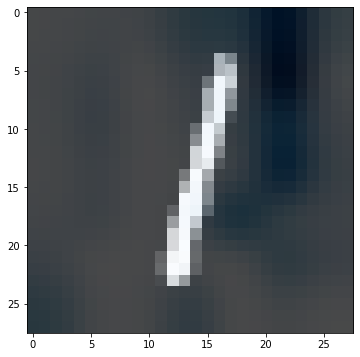

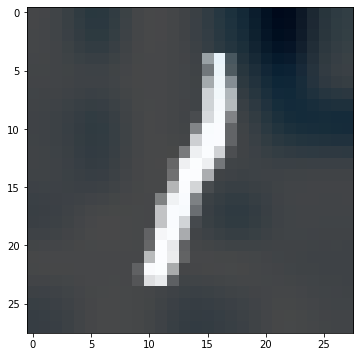

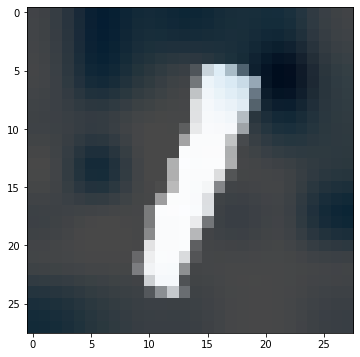

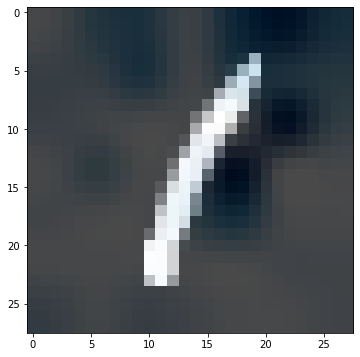

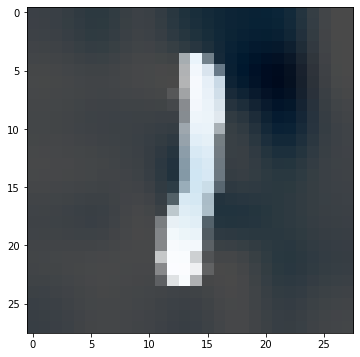

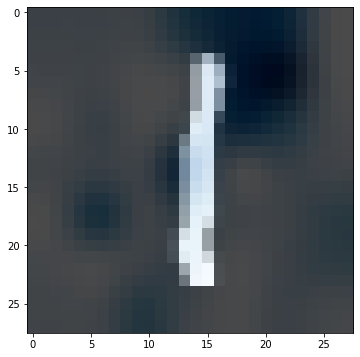

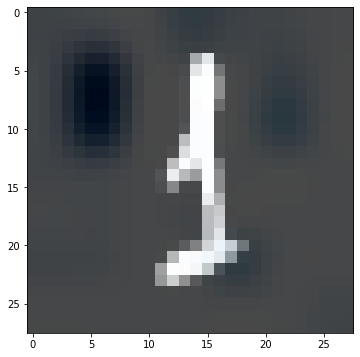

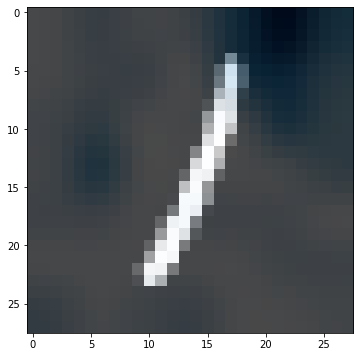

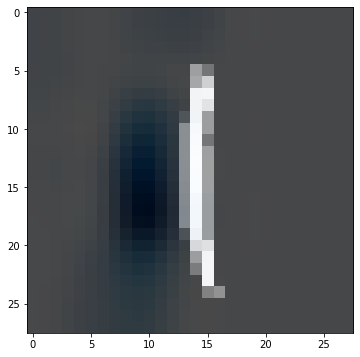

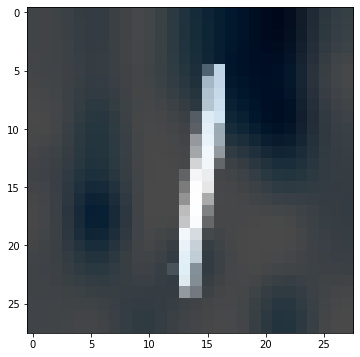

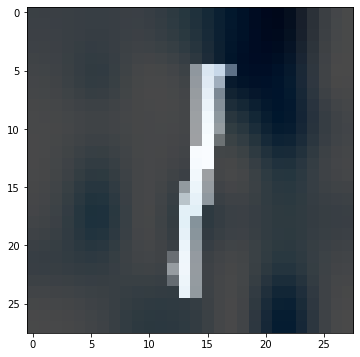

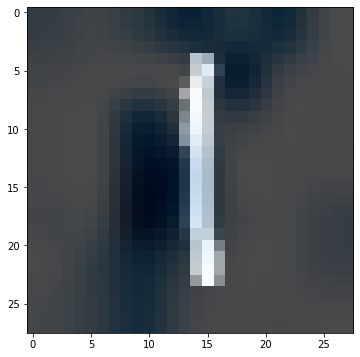

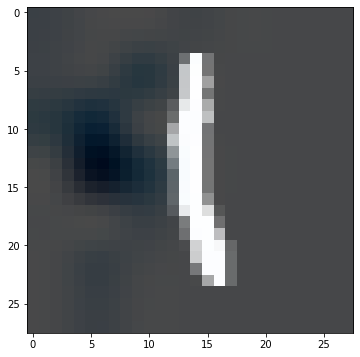

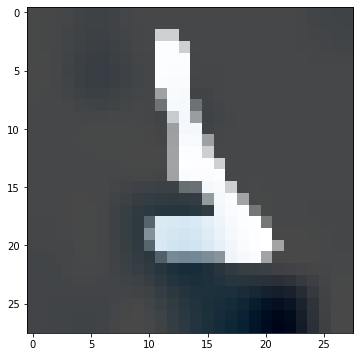

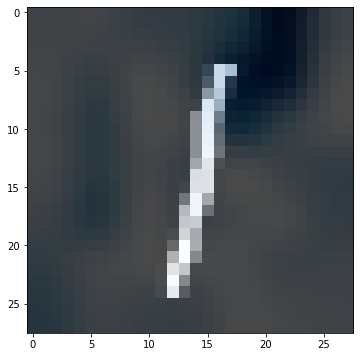

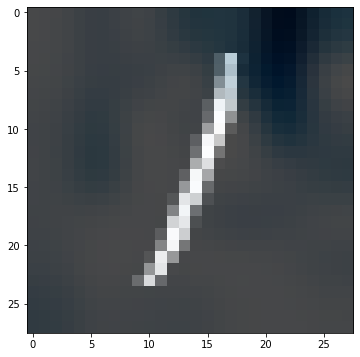

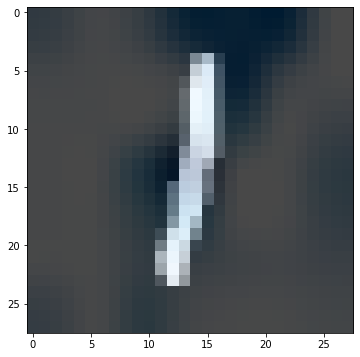

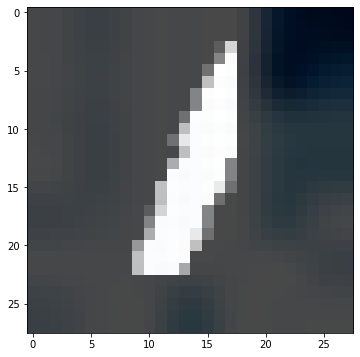

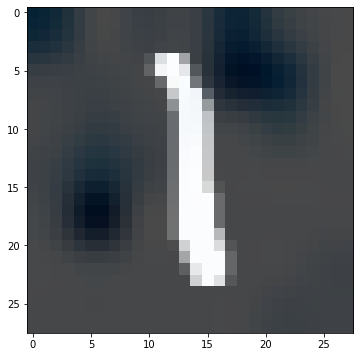

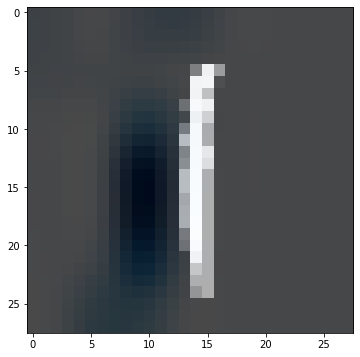

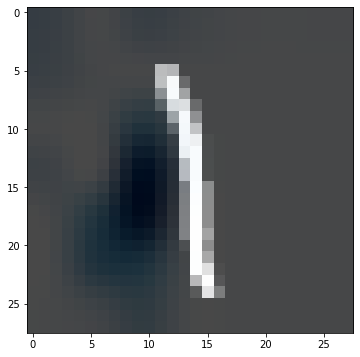

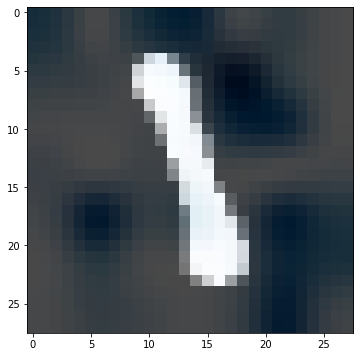

In [31]:
number = 1 # 0~9 사이 확인하고 싶은 숫자
rank = 2 # 1~12 사이 확인하고 싶은 순위

case = int(training_result.iloc[rank-1,0])

exec('N = len(index_{})'.format(number))
exec('heatmap_ = grad_CAMs_case{}[index_{}]'.format(case,number))
exec('img_data_ = temp_data[index_{}]'.format(number))
print("total # of number ",number,": ",N)

for i in range(N):
    heatmap = heatmap_[i]
    img_data = img_data_[i]
    display_gradcam(img_data,heatmap)


total # of number  1 :  2


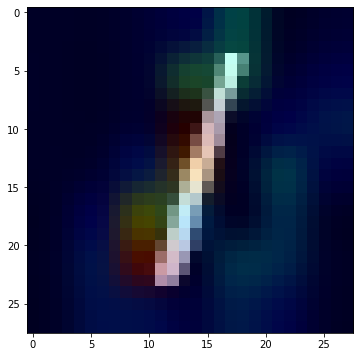

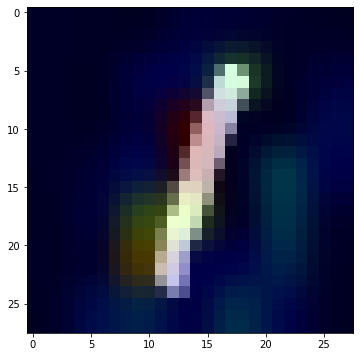

In [ ]:
number = 1 # 0~9 사이 확인하고 싶은 숫자
case = 1 # 1~12 사이 확인하고 싶은 모델

exec('N = len(index_{})'.format(number))
exec('heatmap_ = grad_CAMs_case{}[index_{}]'.format(case,number))
exec('img_data_ = temp_data[index_{}]'.format(number))
print("total # of number ",number,": ",N)

for i in range(N):
    heatmap = heatmap_[i]
    img_data = img_data_[i]
    display_gradcam(img_data,heatmap)


In [ ]:
#원본 + grad CAM 저장 버전

def save_and_display_gradcam(img_data, heatmap, cam_path="./cam.jpg", alpha=0.4):
    # Load the original image
    plt.figure(figsize = (10,10))

    img = keras.preprocessing.image.img_to_array(img_data)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()


save_and_display_gradcam(temp_data[0], heatmap)

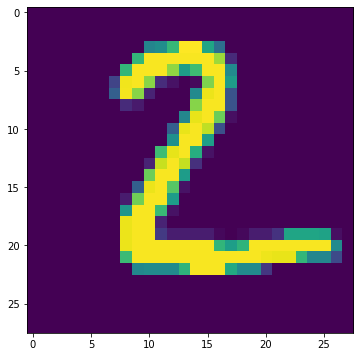

In [ ]:

plt.figure(figsize=(9,6))
plt.imshow(images_test[1].reshape(28,28))
plt.show()


# Grad CAM 함수 세부검토 

In [32]:
pd.set_option('display.max_rows',    500)      # DataFrame 데이터 확인 시 최대 표시 행 수
pd.set_option('display.max_columns', 100)      # DataFrame 데이터 확인 시 최대 표시 열 수

#### 데이터 지정

In [ ]:
for i in range(len(index_0)):
    plt.imshow(images_test[index_0][i].reshape(28,28))
    plt.show()

In [57]:
number = 1 #0~9 사이 mnist set에서 나올 수 있는 숫자 입력

exec('sample = images_test[index_{0}]'.format(number))
# sample = sample.reshape(1, sample.shape[0], sample.shape[1],sample.shape[2])
sample.shape

(126, 28, 28, 1)

#### 함수 파라미터 지정

In [74]:
case = 1 # 분석하고 싶은 model case 입력
data                 = sample
exec('model                = model_case{}'.format(case))
exec('last_conv_layer_name = last_conv_layer_case{}'.format(case))
pred_index           = None

#### grad_model : 입력값에 대한 지정레이어까지의 출력값 및 모델 예측값 출력

First, we create a model that maps the input image to the activations of the last conv layer as well as the output predictions

In [59]:
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
grad_model.summary()

Model: "model_12001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 4)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          

In [60]:
grad_model.layers[-1].activation = tf.keras.activations.linear

In [61]:
grad_model.summary()

Model: "model_12001"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 4)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          

#### class_channel : 입력값에 대한 모델이 분류한 클래스의 스코어

Then, we compute the gradient of the top predicted class for our input image with respect to the activations of the last conv layer

In [62]:
data.shape

(126, 28, 28, 1)

In [78]:
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(data)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]
#     if class_channel.numpy()[0] == 1:
#         class_channel = class_channel-0.000001
    
class_channel

<tf.Tensor: shape=(126,), dtype=float32, numpy=
array([21.986462 , 31.719435 , 27.04594  , 29.198202 , 23.749125 ,
       22.915464 , 29.499794 , 27.19435  , 20.824623 , 26.769691 ,
       23.07691  , 23.403482 , 27.103722 , 13.948395 , 24.363111 ,
       29.261583 , 20.810476 , 24.741383 , 29.866293 , 25.204403 ,
       28.108961 , 27.212004 , 29.810251 , 26.54818  , 24.405289 ,
       20.590391 , 21.220453 , 25.69206  , 28.45008  , 22.026522 ,
       27.333061 , 24.72832  , 21.98551  , 24.910044 , 25.952286 ,
       24.602074 , 24.944252 , 28.690971 , 26.38566  , 31.96768  ,
       24.360846 , 29.042349 , 29.927788 , 26.123676 , 28.515043 ,
       30.015503 , 26.97748  , 24.2057   , 24.731855 , 20.453947 ,
       28.631243 , 20.623198 , 25.079866 , 30.209406 , 25.900013 ,
       24.67008  , 25.43434  , 18.576391 , 29.403057 , 33.066853 ,
       28.342455 , 25.115332 , 30.060575 , 26.920057 , 28.556948 ,
       26.763311 , 24.694065 , 24.336237 , 22.468895 , 18.890291 ,
       30.3759

#### grads : GradientTape 통해 마지막 컨볼루션 레이어 feature map들의 각 요소들로부터 분류 클래스 사이의 weight 계산

This is the gradient of the output neuron (top predicted or chosen) with regard to the output feature map of the last conv layer

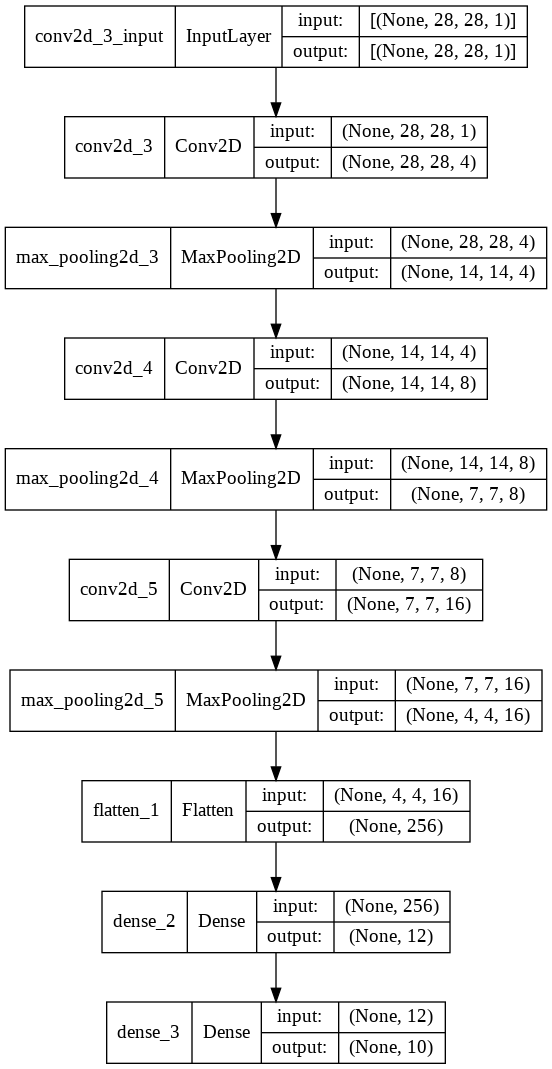

In [77]:
keras.utils.plot_model(model,  show_shapes=True) # 트리형태로 레이어의 입출력 시각화

In [64]:
grads = tape.gradient(class_channel, last_conv_layer_output)
print(grads.numpy().shape)
# grads.numpy()

(126, 7, 7, 16)


#### pooled_grads : 각 feature map 별 weight 평균
This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel

In [66]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2 ))
print(pooled_grads.numpy().shape)
# pooled_grads.numpy()

(16,)


#### last_conv_layer_output : 마지막 컨볼루션 레이어의 feature maps
We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class,
then sum all the channels to obtain the heatmap class activation

In [67]:
last_conv_layer_output = last_conv_layer_output[0]
print(last_conv_layer_output.numpy().shape)
# last_conv_layer_output.numpy()

(7, 7, 16)


#### last_conv_layer_output 및 pooled_grads 행렬곱

In [68]:
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
print(heatmap.numpy().shape)
heatmap.numpy()

(7, 7, 1)


array([[[ 0.02426849],
        [ 0.01903548],
        [-0.04435018],
        [-0.0031634 ],
        [ 1.0385693 ],
        [-0.15651679],
        [ 0.00316957]],

       [[ 0.02593092],
        [-0.00632226],
        [-0.03005912],
        [ 1.0964258 ],
        [ 1.2490231 ],
        [ 0.18301558],
        [ 0.24349222]],

       [[ 0.02593034],
        [-0.00780402],
        [ 0.0267855 ],
        [ 3.0759356 ],
        [-0.01693329],
        [ 0.41624054],
        [ 0.43657896]],

       [[ 0.02306631],
        [-0.03753061],
        [ 0.3783869 ],
        [ 2.3109996 ],
        [ 0.05759064],
        [ 0.5305647 ],
        [ 0.10746627]],

       [[ 0.01063433],
        [ 0.00713105],
        [ 1.7181243 ],
        [ 1.132519  ],
        [ 0.25756648],
        [ 0.6288432 ],
        [ 0.0321133 ]],

       [[ 0.02331185],
        [ 0.18068597],
        [ 1.996347  ],
        [ 0.17256217],
        [ 0.59460604],
        [ 0.47656065],
        [ 0.03305421]],

       [[ 0.01804124],

#### tf.squeeze : 1개 요소 가진 배열 차원 제거

In [69]:
heatmap = tf.squeeze(heatmap)
print(heatmap.numpy().shape)
heatmap.numpy()

(7, 7)


array([[ 0.02426849,  0.01903548, -0.04435018, -0.0031634 ,  1.0385693 ,
        -0.15651679,  0.00316957],
       [ 0.02593092, -0.00632226, -0.03005912,  1.0964258 ,  1.2490231 ,
         0.18301558,  0.24349222],
       [ 0.02593034, -0.00780402,  0.0267855 ,  3.0759356 , -0.01693329,
         0.41624054,  0.43657896],
       [ 0.02306631, -0.03753061,  0.3783869 ,  2.3109996 ,  0.05759064,
         0.5305647 ,  0.10746627],
       [ 0.01063433,  0.00713105,  1.7181243 ,  1.132519  ,  0.25756648,
         0.6288432 ,  0.0321133 ],
       [ 0.02331185,  0.18068597,  1.996347  ,  0.17256217,  0.59460604,
         0.47656065,  0.03305421],
       [ 0.01804124, -0.03018893,  0.34290388, -0.03490172,  0.38662907,
         0.27031052,  0.0248802 ]], dtype=float32)

#### ReLU (0보다 작은 weight 제거) 및 스케일링 (최대값으로 나눠 0~1 min-Max)
For visualization purpose, we will also normalize the heatmap between 0 & 1

In [70]:
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
print(heatmap.numpy().shape)
heatmap.numpy()

(7, 7)


array([[0.00788979, 0.00618852, 0.        , 0.        , 0.33764338,
        0.        , 0.00103044],
       [0.00843025, 0.        , 0.        , 0.35645276, 0.4060628 ,
        0.05949916, 0.07916038],
       [0.00843007, 0.        , 0.00870808, 1.        , 0.        ,
        0.1353216 , 0.14193371],
       [0.00749896, 0.        , 0.12301522, 0.751316  , 0.01872297,
        0.1724889 , 0.03493775],
       [0.00345727, 0.00231834, 0.55856967, 0.36818683, 0.08373598,
        0.20443964, 0.01044017],
       [0.00757878, 0.05874179, 0.649021  , 0.05610071, 0.19330901,
        0.15493193, 0.01074607],
       [0.00586529, 0.        , 0.11147954, 0.        , 0.12569478,
        0.08787912, 0.00808866]], dtype=float32)